In [1]:
import os
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import random
import glob
import nibabel as nib
import numpy as np
from scipy.ndimage import rotate
import csv
import SimpleITK as sitk
#from lungtumormask import mask as tumormask
#from lungmask import mask as lungmask_fun

from monai.utils import first, set_determinism
from monai.transforms import (
    RandFlipd,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    FillHoles,
    KeepLargestConnectedComponent,
    RandCropByPosNegLabeld,
    SaveImaged,
    CenterSpatialCropd,
    SpatialCropd,
    ScaleIntensityRanged,
    Spacingd,
    AsDiscrete,
    SpatialCrop,
    RandSpatialCropd,
    SpatialPadd,
    EnsureTyped,
    EnsureType,
    Invertd,
    DivisiblePadd,
    MapTransform,
    RandWeightedCropd,
    ToTensord,
    Transpose,
    ToTensor,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet,VNet,SwinUNETR,UNETR,DynUNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric,SurfaceDiceMetric,SurfaceDistanceMetric,HausdorffDistanceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch,pad_list_data_collate
from monai.config import print_config
from monai.apps import download_and_extract

if False:
    get_ipython().run_line_magic('matplotlib', 'inline')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
max_epochs = 100

device: cuda


In [3]:
pretrained_path = None
all_patientdir = []
#root_path = '/data/p308104/NBIA_Data/NIFTI_NBIA/imagesTr/'
#root_path = '/data/p308104/Nifti_Imgs_V0/'
#root_path = '/data/p308104/MultipleBP/' #MultipleBP ion peregrine
root_path = '/home/umcg/OneDrive/MultipleBreathingP/'

#NBIA weights
#pretrained_path = '/data/p308104/NBIA_Data/NIFTI_NBIA/imagesTr/best_metric_NBIA_MONAI_V3_lungmask.pth'
#UMCG weights
#pretrained_path = '/data/p308104/Nifti_Imgs_V0/best_metric_UMCG_MONAI_V3_lungmask.pth'
#pretrained_path = '/home/p308104/jobs/Automatic_ITV/weights/'+'best_m_MONAI_V3_UMCGWeightsretrainedWithUMCGdata.pth'
all_patientdir = os.listdir(root_path)
all_patientdir.sort()

In [4]:
CT_fpaths = []
lbl_fpaths= []
lung_fpaths = []
for patient_path in all_patientdir:
    ct_miss = True
    gtv_miss = True
    lung_miss = True
    for root, dirs, files in os.walk(root_path+patient_path, topdown=False):
        for f in files:
            if "50%_ct.nii.gz" in f.lower() and ct_miss:
                CT_fpaths.append(os.path.join(root_path,patient_path,f))
                ct_miss = False
            if "rtstruct_gtv.nii.gz" in f.lower():
                lbl_fpaths.append(os.path.join(root_path,patient_path,f))
                gtv_miss =False
            if '50%_lungmask.nii.gz' in f.lower():
                lung_fpaths.append(os.path.join(root_path,patient_path,f))
                lung_miss = False
        if ct_miss:
            for f in files:
                if "ex_ct.nii.gz" in f.lower() and ct_miss:
                    CT_fpaths.append(os.path.join(root_path,patient_path,f))
                    ct_miss = False
                if 'ex_lungmask.nii.gz' in f.lower() and lung_miss:
                        lung_fpaths.append(os.path.join(root_path,patient_path,f))
                        lung_miss = False
        if gtv_miss and not(ct_miss):
            CT_fpaths.pop()
        if gtv_miss and not(lung_miss):
            lung_fpaths.pop()
        if not(gtv_miss) and (ct_miss):
            print(root)
            for f in files:
                if "mar_ct.nii.gz" in f.lower() and ct_miss:
                    CT_fpaths.append(os.path.join(root_path,patient_path,f))
                    ct_miss = False
                if "in_ct.nii.gz" in f.lower() and ct_miss:
                    CT_fpaths.append(os.path.join(root_path,patient_path,f))
                    ct_miss = False
                if 'mar_lungmask.nii.gz' in f.lower() and lung_miss:
                    lung_fpaths.append(os.path.join(root_path,patient_path,f))
                    lung_miss = False
                if 'in_lungmask.nii.gz' in f.lower() and lung_miss:
                    lung_fpaths.append(os.path.join(root_path,patient_path,f))
                    lung_miss = False
                    
            
print(len(CT_fpaths),len(lbl_fpaths),len(lung_fpaths))
CT_fpaths.sort()
lbl_fpaths.sort()
lung_fpaths.sort()

print(CT_fpaths[44])
print(lbl_fpaths[44])
print(lung_fpaths[44])

/home/umcg/OneDrive/MultipleBreathingP/0170341
/home/umcg/OneDrive/MultipleBreathingP/1642692
190 190 190
/home/umcg/OneDrive/MultipleBreathingP/1372853/1372853_50%_ct.nii.gz
/home/umcg/OneDrive/MultipleBreathingP/1372853/1372853_rtstruct_GTV.nii.gz
/home/umcg/OneDrive/MultipleBreathingP/1372853/1372853_50%_LungMask.nii.gz


In [5]:
data_dicts = [
    {"image": image_name,"lung":lung_name,"label": label_name}
    for image_name,lung_name,label_name in zip(CT_fpaths,lung_fpaths,lbl_fpaths)
]
train_files, val_files = data_dicts[:-50], data_dicts[-50:]
print('train val len:',len(train_files),'-',len(val_files))

minmin_CT = -1024 #NBIA
maxmax_CT = 3071 #NBIA

train val len: 140 - 50


In [6]:

#class to transpose lung mask
class Create_sequences(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)
        
        print(f"keys to transpose: {self.keys}")

         
    def __call__(self, dictionary):
        dictionary = dict(dictionary)
        for key in self.keys:
            data = dictionary[key]
            if key == 'lung':
                data = np.transpose(data, (0,2,3,1))
                data = rotate(data,270,axes=(1,2),reshape=False)
                data = np.flip(data,1)
                data[data==2] = int(1)
                data[data!=1] = int(0)
            dictionary[key] = data
            
        return dictionary        

In [7]:

set_determinism(seed=0)
image_keys = ["image","lung","label"]
p = .5 #Data aug transform probability
size = 96
image_size = (size,size,size)
train_transforms = Compose(
    [
        LoadImaged(keys=image_keys),
        EnsureChannelFirstd(keys=image_keys),
        Orientationd(keys=["image","label"], axcodes="RAS"),
        #Spacingd(keys=["image","label"], pixdim=(1,1,1),mode=("bilinear","nearest")),
        ScaleIntensityRanged(keys=["image"], a_min=minmin_CT, a_max=maxmax_CT,b_min=0.0, b_max=1.0, clip=True,),
        Create_sequences(keys=image_keys),
        CropForegroundd(keys=image_keys, source_key="lung",k_divisible = size),
        RandCropByPosNegLabeld(
            keys=image_keys,label_key='label',spatial_size=image_size,pos=1,neg=1,num_samples=2,
            image_key='image',image_threshold=0,),
        #RandFlipd(keys=image_keys,spatial_axis=[0],prob=p / 3,),
        #RandFlipd(keys=image_keys,spatial_axis=[1],prob=p / 3,),
        #RandFlipd(keys=image_keys,spatial_axis=[2],prob=p / 3,),
        ToTensord(keys=image_keys),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=image_keys),
        EnsureChannelFirstd(keys=image_keys),
        Orientationd(keys=["image","label"], axcodes="RAS"),
        #Spacingd(keys=["image","label"], pixdim=(1,1,1),mode=("bilinear","nearest")),
        ScaleIntensityRanged(keys=["image"], a_min=minmin_CT, a_max=maxmax_CT,b_min=0.0, b_max=1.0, clip=True,),
        Create_sequences(keys=image_keys),
        CropForegroundd(keys=image_keys, source_key="lung",k_divisible = size),
        ToTensord(keys=image_keys),
    ]
)

train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0)

val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=0)#,collate_fn=pad_list_data_collate)


keys to transpose: ('image', 'lung', 'label')
keys to transpose: ('image', 'lung', 'label')


px info:1,image shape: (96, 96, 96),lung shape: (96, 96, 96), label shape: (96, 96, 96)


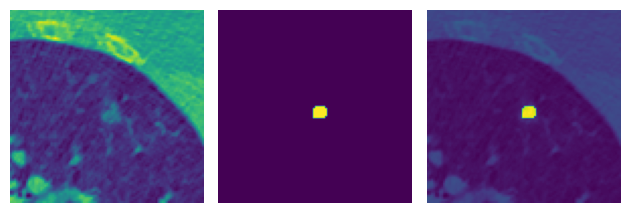

px info:2,image shape: (96, 96, 96),lung shape: (96, 96, 96), label shape: (96, 96, 96)
px info:3,image shape: (96, 96, 96),lung shape: (96, 96, 96), label shape: (96, 96, 96)


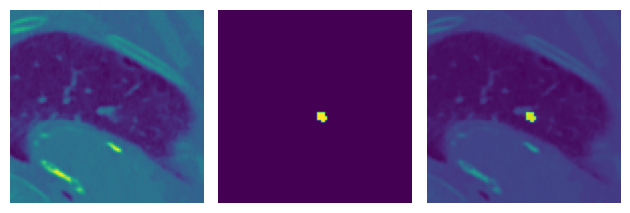

KeyboardInterrupt: 

In [12]:
#Check the images after the preprocessing
if True:
    check_ds =Dataset(data=train_files, transform=train_transforms)
    check_loader = DataLoader(check_ds, batch_size=1,num_workers=0)
    if True:
        count = 1
        for batch_data in check_loader:
            #batch_data = first(check_loader)
            image,lung, label = (batch_data["image"][0][0],batch_data["lung"][0][0],batch_data["label"][0][0])
            print(f"px info:{count },image shape: {image.shape},lung shape: {lung.shape}, label shape: {label.shape}")
            count+=1
            for i in range(label.shape[2]):
                if torch.sum(label[:,:,i])>0:
                    plt.subplot(1,3,1),plt.imshow(image[:,:,i]),plt.axis('off')
                    plt.subplot(1,3,2),plt.imshow(label[:,:,i]),plt.axis('off')
                    plt.subplot(1,3,3),plt.imshow(label[:,:,i]+image[:,:,i]),plt.axis('off')
                    plt.tight_layout(),plt.show()
                    break
            if count>10:
                break

In [8]:
in_channels = 1
out_channels=2 #including background
model = SwinUNETR(
    image_size, 
    in_channels, out_channels, 
    use_checkpoint=True, 
    feature_size=24,
    #spatial_dims=spatial_dims
).to(device)

In [9]:

loss_function = DiceLoss(to_onehot_y=True, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")


post_pred = Compose([EnsureType(), AsDiscrete(argmax=True,threshold=0.5)])
post_label = Compose([EnsureType(), AsDiscrete(threshold=0.5)],)

# Load pretrained model
if pretrained_path is not(None):
    model.load_state_dict(torch.load(pretrained_path, map_location=torch.device(device)))

    #weight = torch.load(pretrained_path, map_location=torch.device(device))
    #model.load_from(weights=weight)
    print('Using pretrained weights!')

metric_values = []
nr_images = 8
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

In [10]:

for epoch in range(max_epochs):
    print("-" * 60)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs,labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
    

------------------------------------------------------------
epoch 1/100


RuntimeError: Unable to find a valid cuDNN algorithm to run convolution